## In this project, I will be examining trends in global temperatures from the 18th century onwards and creating visuals to convey general conclusions. 

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import zipfile, os
from TemperatureGrapher import TemperatureGrapher

In [16]:
#Opening the files
zf = zipfile.ZipFile(os.getcwd() + "/Data.zip") 
country_temps=pd.read_csv(zf.open("GlobalLandTemperaturesByCountry.csv"))
country_temps_average=country_temps.groupby("dt").mean()
world_temps=pd.read_csv(zf.open("GlobalTemperatures.csv"))
world_temps = world_temps.rename(columns=
    {"LandAverageTemperature": "AverageTemperature", 
    "LandAverageTemperatureUncertainty": "AverageTemperatureUncertainty"}).drop(world_temps.iloc[:,3:], axis=1)
world_temps_average=world_temps.groupby("dt").mean()
maj_city_temps=pd.read_csv(zf.open("GlobalLandTemperaturesByMajorCity.csv"))
state_temps=pd.read_csv(zf.open("GlobalLandTemperaturesByState.csv"))
state_temps_average=state_temps.groupby("dt").mean()
city_temps=pd.read_csv(zf.open("GlobalLandTemperaturesByCity.csv"))
city_temps_average=city_temps.groupby("dt").mean()

In [17]:
TG = TemperatureGrapher()

## First, I will draw several maps displaying the heat distribution across the globe in each century. Because there was little data in the 18th century, its map is less filled out than the others. 

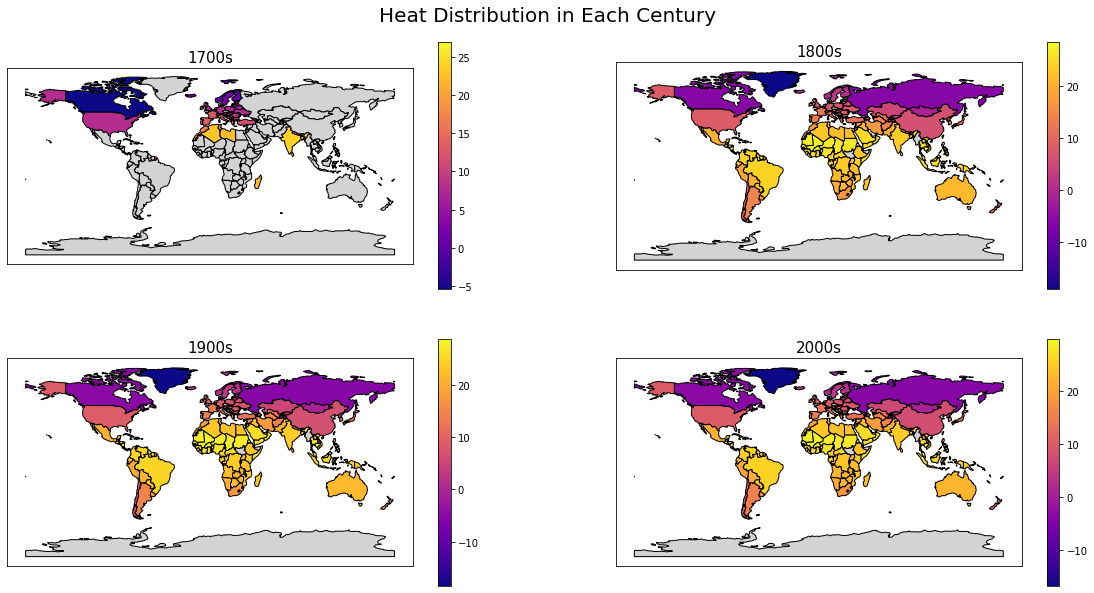

In [18]:
"""
A few countries have different names in the datasets I'm using compared to the naturalearth_lowres world dataset. As a result, I had to rename a few countries.
"""
oldNames = ["Palestina", "Dominica","French Guiana", "Netherlands (Europe)", "Bosnia And Herzegovina", "United States", "Central African Republic", "Trinidad And Tobago", "Timor Leste", "Congo (Democratic Republic Of The)", "Côte D'Ivoire"]
newNames = ["Palestine", "Dominican Rep.", "Guinea", "Netherlands", "Bosnia and Herz.", "United States of America", "Central African Rep.", "Trinidad and Tobago", "Timor-Leste", "Dem. Rep. Congo", "Côte d'Ivoire"]
for i in range(len(oldNames)):
    country_temps.loc[country_temps["Country"] == oldNames[i], "Country"] = newNames[i]

fig, heatAxs=plt.subplots(2,2, figsize=(20,10)) 
fig.patch.set_facecolor("white")
plt.suptitle("Heat Distribution in Each Century", fontsize=20,y=.93)

rows,cols = [0,0,1,1],[0,1,0,1]
centuries = range(17,21)

for i in range(len(centuries)):
    TG.graph_map(country_temps, centuries[i], rows[i], cols[i], heatAxs)


## The following code will create four graph to display how the average temperature worldwide has changed each year. 
## As we can see below, the average temperature has been consistently increasing since the 18th century. In some graphs, there is a surge in the mid-1800s. However, it is also important to note that uncertainty about the data was much higher earlier on.


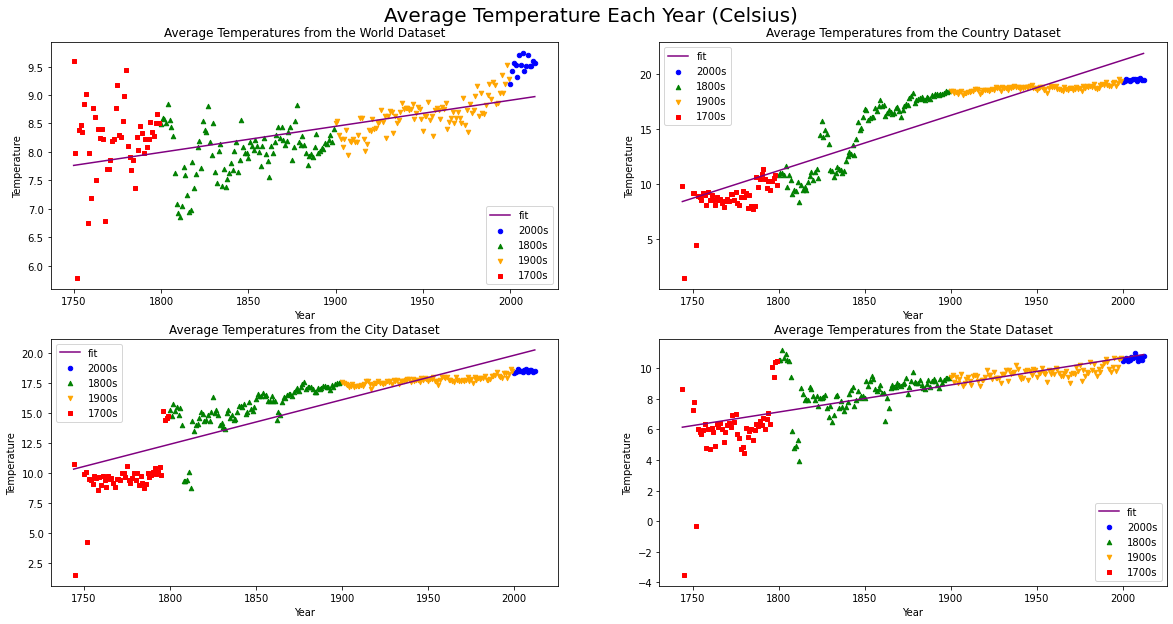

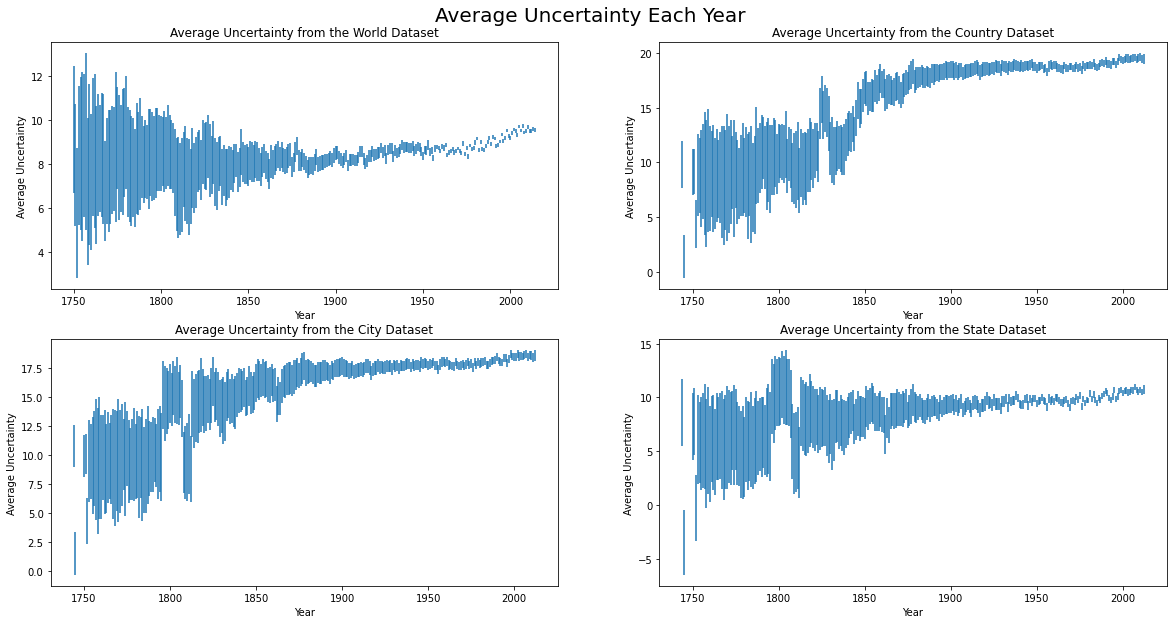

In [19]:
fig, tempAx=plt.subplots(2,2, figsize=(20,10)) 
plt.suptitle("Average Temperature Each Year (Celsius)", fontsize=20,y=.93)
fig, uncertainAx=plt.subplots(2,2, figsize=(20,10)) 
plt.suptitle("Average Uncertainty Each Year", fontsize=20,y=.93)

#Graphing the average temperature and uncertainty across different data sets.
rows,cols = [0,0,1,1], [1,0,0,1]
dataframes = [country_temps_average, world_temps_average, city_temps_average, state_temps_average]
regionNames = ["Country", "World", "City", "State"]
for i in range(len(rows)):
    TG.graph_change(regionNames[i],dataframes[i], tempAx,uncertainAx,rows[i],cols[i])


## Below, I will display which areas have had the highest increase in temperature. 
## It is important to note that different areas began recording temperatures at different times. As a result, places that began recording later will have fewer low temperatures recorded (due to the consistent increase in temperatures with time), weighing down their average. To avoid a possible misrepresentation, I grouped the areas based on when they began recording. 

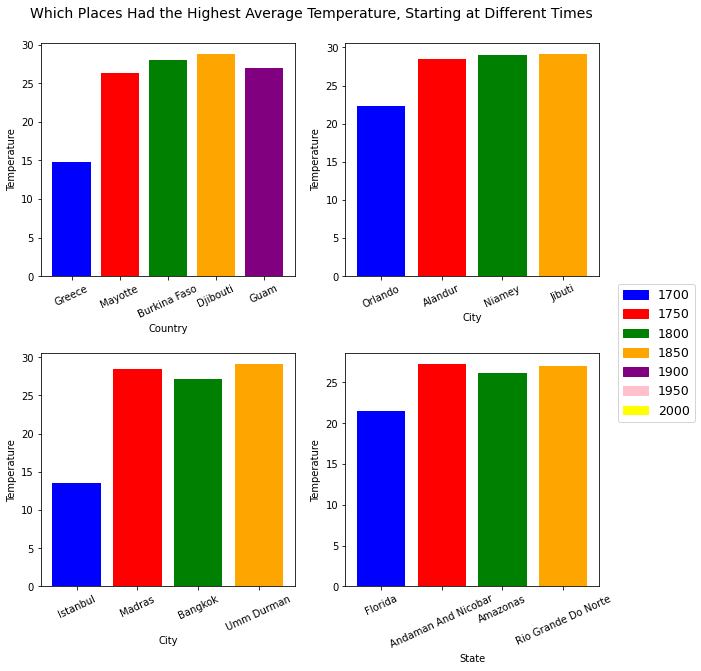

In [20]:
fig, timeAxs=plt.subplots(2,2, figsize=(10,10)) 
plt.subplots_adjust(hspace=.33)
plt.suptitle("Which Places Had the Highest Average Temperature, Starting at Different Times", fontsize=14,y=.93)

dataframes = [country_temps, city_temps, maj_city_temps, state_temps]
places = ["Country","City", 'City', "State"]
rows,cols = [0,0,1,1], [0,1,0,1]
for i in range(len(dataframes)):
    TG.highest_avg(dataframes[i], places[i], rows[i], cols[i],timeAxs)
